In [1]:
#!/usr/bin python3
import itertools
import json
import numpy as np
import pandas as pd
import random
from sklearn import metrics
import seaborn as sns
from tabulate import tabulate
import torch
import torch.backends.mps
from torch.utils.data import DataLoader

from utils import data_utils, data_loader, model_utils
from models import avg_speed, avg_speed_seq, time_table, basic_ff, basic_rnn, gru_rnn

import importlib

torch.set_default_dtype(torch.float)

run_folder = "../results/debug/"
network_folder = "kcm/"

if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

### Set run and hyperparameters
EPOCHS = 20
BATCH_SIZE = 512
LEARN_RATE = 1e-3
HIDDEN_SIZE = 32

### Load train/test data
print("="*30)
data_folder = run_folder + network_folder + "deeptte_formatted/"
print(f"Loading data from '{data_folder}'...")
# Load config
with open(data_folder + "config.json", "r") as f:
    config = json.load(f)
# Load GTFS-RT samples
train_data_chunks, valid_data = data_utils.load_train_test_data(data_folder, config['n_folds']) # Validation data no longer used
# Load GTFS data
print(f"Loading and merging GTFS files from '{config['gtfs_folder']}'...")
gtfs_data = data_utils.merge_gtfs_files("."+config['gtfs_folder'])

Using device: cuda
Loading data from '../results/throwaway/kcm/deeptte_formatted/'...
Loading and merging GTFS files from './data/kcm_gtfs/2023_01_23/'...


In [2]:
fold_num = 0
importlib.reload(data_loader)
# Set aside the train/test data according to the current fold number
test_data = train_data_chunks[fold_num]
train_data = [x for i,x in enumerate(train_data_chunks) if i!=fold_num]
# Combine the training data to single object
train_data = list(itertools.chain.from_iterable(train_data))

# Construct dataloaders for Pytorch models
train_dataloader = data_loader.make_generic_dataloader(train_data, config, BATCH_SIZE, "basic")
test_dataloader = data_loader.make_generic_dataloader(test_data, config, BATCH_SIZE, "basic")
train_dataloader_seq = data_loader.make_generic_dataloader(train_data, config, BATCH_SIZE, "sequential")
test_dataloader_seq = data_loader.make_generic_dataloader(test_data, config, BATCH_SIZE, "sequential")
train_lens, train_mask = data_utils.get_seq_info(train_dataloader_seq)
test_lens, test_mask = data_utils.get_seq_info(test_dataloader_seq)
print(f"Successfully loaded {len(train_data)} training samples and {len(test_data)} testing samples.")

# Define embedded variables for nn models
embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4
    },
    'driverID': {
        'vocab_size': config['n_unique_veh'],
        'embed_dims': 6
    },
    'tripID': {
        'vocab_size': config['n_unique_trip'],
        'embed_dims': 20
    }
}

Successfully loaded 261219 training samples and 65413 testing samples.


In [3]:
for i, data in enumerate(train_dataloader_seq):
    inputs, labels = data
    inputs[:2] = [i.to(device) for i in inputs[:2]]
    labels = labels.to(device)
    hidden_prev = torch.zeros(1, len(data[1]), HIDDEN_SIZE).to(device)

In [4]:
### Train RNN model
print("="*30)
print(f"Training rnn model...")
rnn_model = gru_rnn.GRU_RNN(
    5,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict
).to(device)
rnn_train_losses, rnn_test_losses = model_utils.fit_to_data(rnn_model, train_dataloader_seq, test_dataloader_seq, LEARN_RATE, EPOCHS, config, device, sequential_flag=True)
torch.save(rnn_model.state_dict(), run_folder + network_folder + f"models/rnn_model_{fold_num}.pt")
rnn_labels, rnn_preds, rnn_avg_loss = model_utils.predict(rnn_model, test_dataloader_seq, device, sequential_flag=True)
rnn_labels = data_utils.de_normalize(rnn_labels, config['speed_m_s_mean'], config['speed_m_s_std'])
rnn_preds = data_utils.de_normalize(rnn_preds, config['speed_m_s_mean'], config['speed_m_s_std'])

Training rnn model...
EPOCH: 0
LOSS: train 0.2576126605855509 valid 0.19154726469423622
EPOCH: 1
LOSS: train 0.18223761115405424 valid 0.17787964921444654
EPOCH: 2
LOSS: train 0.17491915902221272 valid 0.17338630638550967
EPOCH: 3
LOSS: train 0.1729759713762427 valid 0.17049150611273944
EPOCH: 4
LOSS: train 0.16972787907153894 valid 0.16842911497224122
EPOCH: 5
LOSS: train 0.1667264845302427 valid 0.16345408686902374
EPOCH: 6
LOSS: train 0.1622070759505675 valid 0.16152826324105263
EPOCH: 7
LOSS: train 0.1608671000675679 valid 0.1590141276246868
EPOCH: 8
LOSS: train 0.15831514443553357 valid 0.15747349010780454
EPOCH: 9
LOSS: train 0.15711703244778974 valid 0.15658597636502236
EPOCH: 10
LOSS: train 0.1563455365058727 valid 0.15649272105656564
EPOCH: 11
LOSS: train 0.15917773778074643 valid 0.1600443221977912
EPOCH: 12
LOSS: train 0.155544124995659 valid 0.15623442793730646
EPOCH: 13
LOSS: train 0.15466523610799046 valid 0.15476516186026856
EPOCH: 14
LOSS: train 0.1544311729983341 valid

In [5]:
rnn_preds_tt = data_utils.convert_speeds_to_tts(rnn_preds, test_dataloader_seq, test_mask, config)
rnn_labels_tt = data_utils.convert_speeds_to_tts(rnn_labels, test_dataloader_seq, test_mask, config)
print(np.round(metrics.mean_absolute_error(rnn_labels_tt, rnn_preds_tt), 2))
print(np.round(np.sqrt(metrics.mean_squared_error(rnn_labels_tt, rnn_preds_tt)), 2))

312.5
5766.69


In [6]:
len(rnn_preds_tt[rnn_preds_tt>10000])

85

<Axes: ylabel='Count'>

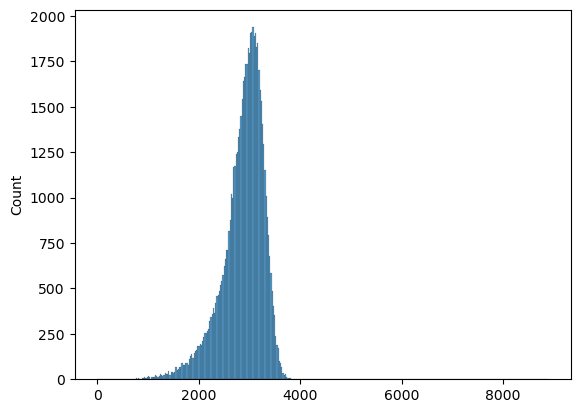

In [7]:
sns.histplot(rnn_preds_tt[rnn_preds_tt<10000])

In [8]:
np.max(rnn_preds_tt)

344904.88

<Axes: ylabel='Count'>

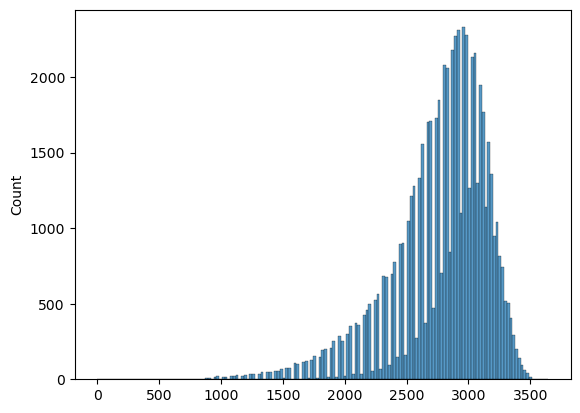

In [9]:
sns.histplot(rnn_labels_tt)

In [10]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        preds, hidden_prev = rnn_model(inputs, hidden_prev)
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                           Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                model_inference         7.73%       1.036ms        99.79%      13.378ms      13.378ms     880.000us         6.56%      13.382ms      13.382ms             1  
    aten::_pack_padded_sequence        14.19%       1.902ms        42.34%       5.676ms       5.676ms       1.193ms         8.90%       5.683ms       5.683ms             1  
     aten::_pad_packed_sequence        13.26%       1.778ms        29.79%       3.993ms       3.993ms       1.063ms         7.93%

<Axes: xlabel='Epoch', ylabel='value'>

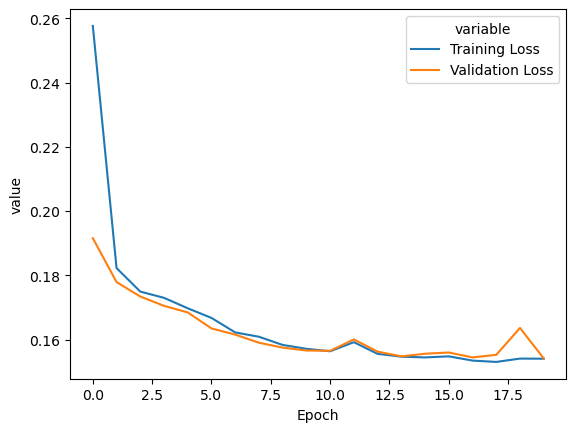

In [11]:
# Plot training curves
plot_data = pd.DataFrame(
    {
        "Epoch": [x for x in range(0,len(rnn_train_losses))],
        "Training Loss": rnn_train_losses,
        "Validation Loss": rnn_test_losses
    }
)
sns.lineplot(x='Epoch', y='value', hue='variable', data=pd.melt(plot_data, ['Epoch']))